In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Exploration
## Import relevant libraries

In [ ]:
#for reading data
import pandas as pd

#for numerical computaions
import numpy as np

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

## read the data

In [ ]:
#define a path to local stoarge
path = '/Users/user/Downloads/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv'

cloud_path = '/content/drive/MyDrive/data_science/toxicity_dataset_uncleaned.csv'

#read the data
data = pd.read_csv(cloud_path)

#view the top 10 rows
data.head(10)

,Unnamed: 0,comment_text,toxic_class
0,0,He's consulting with the likes of Barbara Hack...,0
1,1,Why would POTUS denigrate our allies and push ...,0
2,2,"Talk about "" illiterate gibberish."" Which btw ...",0
3,3,Payed for by you. What did people expect from ...,0
4,4,Cool...far out man.....in so many ways.....,0
5,5,Don't blame any part of this on the Dems. They...,0
6,6,It used to have both. That is a picture of ol...,0
7,7,I did. Don't shrink Jesus message to us. He ...,0
8,8,"Need, maybe, but desire to own a car will stil...",0
9,9,who cares about the aga khan? another rich en...,0


In [ ]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

## Data exploration

In [ ]:
#length of the data
data.shape

- there are 1.9 million rows and 46 columns in the data

In [ ]:
data.columns

- only 'comment_text', 'toxicity' columns are necessary for our analysis

In [ ]:
#make a subset of the original data that excludes other column names except 'comment_text' and 'toxicity'
new_data = data[['comment_text', 'toxicity']]

#make a copy of it
data = new_data.copy()

In [ ]:
#check for missing values
data.isnull().sum()

comment_text    1
toxicity        0
dtype: int64

- there is only one missing value in the comment_text column and i will drop it.

In [ ]:
data.dropna(subset=['comment_text'], inplace=True) #drops the missing value

In [ ]:
#check for missing values
data.isnull().sum()

comment_text    0
toxicity        0
dtype: int64

In [ ]:
# check for duplicates
data.duplicated().sum()

694

- there are 21,713 duplicated rows in the data. I will drop them because this will help me lower the chances of overfiting

In [ ]:
#drop the duplicated rows
data.drop_duplicates(inplace=True)

#reset index
data.reset_index(drop=True, inplace=True)

In [ ]:
# check for duplicates
data.duplicated().sum()

0

- the duplicates have been dropped

####  a new column named 'toxic_class' will be engineered and it is value will be dependent on the corresponding value of toxicity in that row.
- toxicity value => 0.5 will be 1 in toxic_class
- toxicity value < 0.5 will be 0 in toxic_class

In [ ]:
def toxic_annot(var):
    """
    this function appends value 0 or 1 depending on the value of the var in the column it was applied
    """
    #if value is less than 0.5
    if var < 0.5:
    #value for new column is 0
        new_var = 0
        return new_var #return 0

    elif var >= 0.5: #if value is >= 0.5
        new_var = 1  #new value is 1
        return new_var   #return new value

In [ ]:
#apply the function to the toxicity column and save the result in a new column
data['toxic_class'] = data['toxicity'].apply(toxic_annot)


In [ ]:
data.head()

,comment_text,toxic_class
0,He is consulting with the likes of Barbara Hacket ...,0
1,Why would POTUS denigrate our allies and push them to cooperate with our adversaries?,0
2,"Talk about "" illiterate gibberish."" Which by the way it is spelled American not ""Amurcan"". How is your occupation of Yellowstone going? \n\n""ericnorstog 4 days ago""\n\n""I call dibs on Old Faithful, plus the lodge! Do not get in my way, I will be heavily armed, so as not to be arrested. That will cost the taxpayers so much money, they will howl! Then the jury will find me innocent of all charges, I can go on right wing talk shows and tell everyone how to do it. Yeah! That is the ticket! I will be a True Amurcan Patriot, and get on The Donald Trump News Hour! Yes! I am going for it! Manager!""",0
3,Payed for by you. What did people expect from some one who lost a Republican primary then ran as Independent and then some how pushed aside the guy that won the Democrat primary and took his place. All that just for one term. Ya Right.,0
4,Cool...far out man.....in so many ways.....,0


In [ ]:
from utils import labeled_barplot, histogram_boxplot

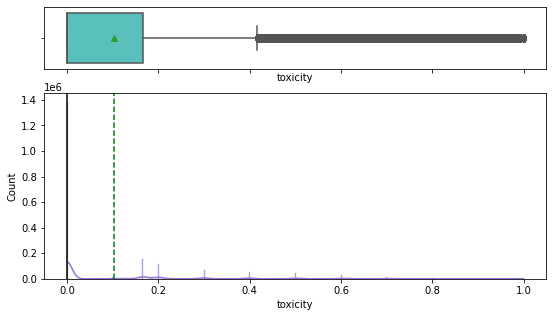

In [ ]:
histogram_boxplot(data, feature='toxicity', kde=True)

- these plots indicate that the toxicity data is right-skewed which means there most of the comments were non-toxic and fewer number of the comments were considered to be toxic.

In [ ]:
labeled_barplot(data=data, feature='toxic_class', perc=True)

- the dataset is highly imbalanced in favour of no-toxic (0) class. This will most likely result in bias because the model might perform better in predicting class 0 relative to class 1.

- since the '1' class is very small, randomly selecting 10% of the data will reduce the data point of category '1' further and this might be disadvantageous to the model.
- I will first implement Random Undersampling technique.
- this will result in having twice the amount of datapoints in '1' which is 319,006.
- Then i will randomly select the required amount of data

In [ ]:
#implement random undersampling

from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#create an instance of the random sampler
rus = RandomUnderSampler(random_state=42)

#define features
X = data.drop(labels=['toxic_class'], axis=1)

#define target
Y = data['toxic_class']

#apply undersampling
x_res, y_res = rus.fit_resample(X, Y)


In [ ]:
#re-join the resampled feature to the resampled target
new_data = pd.concat([x_res, y_res], axis=1)

#view a sample of the data
new_data.sample()

,comment_text,toxicity,toxic_class
124637,"From the article; ""For me, one of the big prob...",0.166667,0


In [ ]:
new_data['toxic_class'].value_counts()

0    159503
1    159503
Name: toxic_class, dtype: int64

- the dataset is balanced

In [ ]:
#length of new data
new_data.shape

(319006, 3)

- the resampled data has 319,006 rows and 3 columns

In [ ]:
#Identify the classes
classes = new_data['toxic_class'].unique()

#Group the DataFrame by class and get the count
class_counts = new_data.groupby('toxic_class').size()

#Calculate the number of data points to select
num = int(0.1 * len(data))

#Calculate the desired number of samples from each class
num_per_class = int(num / len(classes)) #this is the number of samples we want from each sub category

#Randomly select 'num_per_class' samples from each subcategory
random_samples = new_data.groupby('toxic_class').apply(lambda x: x.sample(n=num_per_class, random_state=42)).reset_index(drop=True)


In [ ]:
random_samples['toxic_class'].value_counts()

0    98890
1    98890
Name: toxic_class, dtype: int64

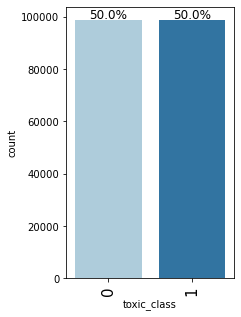

In [ ]:
labeled_barplot(data=random_samples, feature='toxic_class', perc=True)

- now I have a balanced dataset and exactly 10% of the original dataset after duplicates were removed.

In [ ]:
#random_samples.sample(5)

- drop toxicity column

In [ ]:
random_samples.drop(labels=['toxicity'], axis=1,inplace=True)

In [ ]:
data = random_samples.copy()

data.head()

,comment_text,toxic_class
0,He's consulting with the likes of Barbara Hacket ...,0
1,Why would POTUS denigrate our allies and push them to cooperate with our adversaries?,0
2,"Talk about "" illiterate gibberish."" Which btw it's spelled American not ""Amurcan"". How is your occupation of Yellowstone going? \n\n""ericnorstog 4 days ago""\n\n""I call dibs on Old Faithful, plus the lodge! Don't get in my way, I will be heavily armed, so as not to be arrested. That'll cost the taxpayers so much money, they'll howl! Then the jury will find me innocent of all charges, I can go on right wing talk shows and tell everyone how to do it. Yeah! That's the ticket! I will be a True Amurcan Patriot, and get on The Donald Trump News Hour! Yes! I'm going for it! Manager!""",0
3,Payed for by you. What did people expect from some one who lost a Republican primary then ran as Independent and then some how pushed aside the guy that won the Democrat primary and took his place. All that just for one term. Ya Right.,0
4,Cool...far out man.....in so many ways.....,0


## save the new dataset

In [ ]:
data.to_csv('/Users/user/Downloads/toxicity_dataset_uncleaned.csv', index=False)

# NLP Text Preprocessing

In [ ]:
import pandas as pd

#for text preprocessing and cleaning
import re #data cleaning and remove unwanted characters
import nltk #to remove stopwords, implement lematization and tokenization
import string #to clean data
#import unidecode, unicodedata #to remove non-ascii characters


#to display wordcloud
from wordcloud import WordCloud, STOPWORDS

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#to show max width
pd.set_option('max_colwidth', None)

# Helps to display the images
from PIL import Image #pillow library

In [ ]:
!pip install --upgrade pip

!pip install --upgrade Pillow

In [ ]:
data.head()

,comment_text,toxic_class
0,He's consulting with the likes of Barbara Hacket ...,0
1,Why would POTUS denigrate our allies and push them to cooperate with our adversaries?,0
2,"Talk about "" illiterate gibberish."" Which btw it's spelled American not ""Amurcan"". How is your occupation of Yellowstone going? \n\n""ericnorstog 4 days ago""\n\n""I call dibs on Old Faithful, plus the lodge! Don't get in my way, I will be heavily armed, so as not to be arrested. That'll cost the taxpayers so much money, they'll howl! Then the jury will find me innocent of all charges, I can go on right wing talk shows and tell everyone how to do it. Yeah! That's the ticket! I will be a True Amurcan Patriot, and get on The Donald Trump News Hour! Yes! I'm going for it! Manager!""",0
3,Payed for by you. What did people expect from some one who lost a Republican primary then ran as Independent and then some how pushed aside the guy that won the Democrat primary and took his place. All that just for one term. Ya Right.,0
4,Cool...far out man.....in so many ways.....,0


## Display wordcloud for toxic and non-toxic comments

In [ ]:
def WordCloudGen(data, comment_class):
    """
    this function generates a word cloud based on the specified comment class
    data: dataframe
    comment_class: category {0: non toxic, 1: toxic}
    """
    #step1: define the comment category
    comments = data[data['toxic_class'] == comment_class] #this will return a subset of the data with specified
    #comment class

    #step2: join the words in the comment text
    joined_comments = " ".join(comments['comment_text'])
    #this will join the comments together

    #step3: tokenize the words into a list of words
    tokens = " ".join([comments for comments in joined_comments.split()])

    #step4: intialize the wordcloud
    wc = WordCloud(stopwords=STOPWORDS, random_state=14, width=3000, height=2500,).generate(tokens)

    #set the figure
    plt.figure(1, figsize=(12,12))

    #display the wordcloud image
    plt.imshow(wc, interpolation='bilinear')

    #off the axis
    plt.axis('off')

    #show the plot
    plt.show()

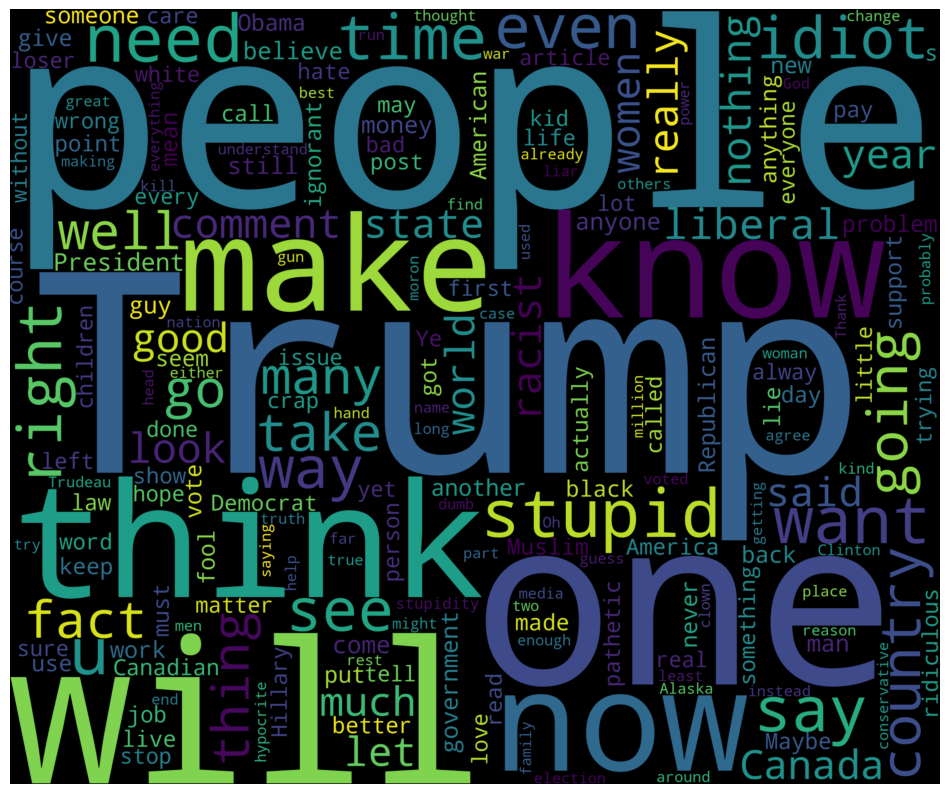

In [ ]:
WordCloudGen(data, 1)

## Removing Contractions (converting words like "It's" to "It is")

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.1 MB/s eta 0:00:00


In [ ]:
import contractions

In [ ]:
def contraction_fixer(comments):
    """
    this function fixes the contractions found in the sentence and returns a comments with no contractions.
    comments: string of words
    """
    fixed_comments = contractions.fix(comments)
    return fixed_comments

In [ ]:
data['comment_text'] = data['comment_text'].apply(contraction_fixer)

## Remove unwanted characters such as: digits and punctuation marks & special charcaters

In [ ]:
text = "123for    real_life is... a @@ * /n g00dpass c)ded"

re.sub(pattern="[^a-zA-Z]", repl=" ", string=text)

'   for    real life is    a       n g  dpass c ded'

In [ ]:
def text_cleaner(comment):
    """
    this function removes unwanted characters such as: digits and punctuation marks, extra
    whitespaces & special charcatersfound in comment.
    it will return only uppercase and lowecased alphabets.
    comment: string of words
    """
    cleaned_comment = re.sub(pattern = "[^a-zA-Z]", repl=" ", string=comment)
    cleaned_comment = re.sub(pattern = "\s+", repl=" ", string=cleaned_comment)
    return cleaned_comment

In [ ]:
data["comment_text"] = data["comment_text"].apply(lambda row: text_cleaner(row))

In [ ]:
data.head()

,comment_text,toxic_class
0,He is consulting with the likes of Barbara Hacket,0
1,Why would POTUS denigrate our allies and push them to cooperate with our adversaries,0
2,Talk about illiterate gibberish Which by the way it is spelled American not Amurcan How is your occupation of Yellowstone going ericnorstog days ago I call dibs on Old Faithful plus the lodge Do not get in my way I will be heavily armed so as not to be arrested That will cost the taxpayers so much money they will howl Then the jury will find me innocent of all charges I can go on right wing talk shows and tell everyone how to do it Yeah That is the ticket I will be a True Amurcan Patriot and get on The Donald Trump News Hour Yes I am going for it Manager,0
3,Payed for by you What did people expect from some one who lost a Republican primary then ran as Independent and then some how pushed aside the guy that won the Democrat primary and took his place All that just for one term Ya Right,0
4,Cool far out man in so many ways,0


## Lowercase the text

In [ ]:
def lowercase(comment):
    """
    returns a lowercased string of comment.
    comment: string of words
    """
    #step1: lowercase each word in the list of tokens
    lowercased_comment = [comment.lower() for comment in comment.split()]
    #step 2: join the words together
    text = " ".join(lowercased_comment)
    #step 3: return text
    return text

In [ ]:
data["comment_text"] = data.apply(lambda x: lowercase(x['comment_text']), axis=1)

## Remove Stopwords

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#step1: import corpus
from nltk.corpus import stopwords

#step2: initializa stopwords found in the english languague so far
stopword = stopwords.words('english')

#step3: define a function to remove stopwords found in the comments
def stopword_remover(comment):
    """
    the function removes stopwords found in the comments and returns the remaining word
    comment: string of words
    """
    #remove the word if the word is a stopword
    cleaned_comment = [text for text in comment.split() if text not in stopword]

    #join the remiaining words back together
    cleaned_comment = " ".join(cleaned_comment)

    #return the cleaned_comment
    return cleaned_comment

#step4: apply the function to the commemt text
data["comment_text"] = data.apply(lambda x: stopword_remover(x['comment_text']), axis=1)

## Apply Lemmatization: return the root word for a particular word. (example: returns 'dog' for 'dogs')

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

KeyboardInterrupt: ignored

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#step1: import wordnetlemmatizer(wnl)
from nltk.stem import WordNetLemmatizer

#step2: initialize the wnl
wnl = WordNetLemmatizer()

#step3: define a function to apply lemmatization to words found in comments
def lemmatizer(comment):
    """
    the function lemmatize the words in the comment
    comment: string of words
    """
    #remove the word if the word is a stopword
    cleaned_comment = [wnl.lemmatize(text) for text in comment.split()]

    #join the remiaining words back together
    cleaned_comment = " ".join(cleaned_comment)

    #return the cleaned_comment
    return cleaned_comment

#step4: apply the function to the commemt text
data["comment_text"] = data.apply(lambda x: lemmatizer(x['comment_text']), axis=1)

## remove punctuations

In [ ]:
def remove_punctuation(comment):
    cleaned_comment = [word for word in comment.split() if word not in string.punctuation]

    #join the remiaining words back together
    cleaned_comment = " ".join(cleaned_comment)

    return cleaned_comment

In [ ]:
data["comment_text"] = data.apply(lambda x: remove_punctuation(x['comment_text']), axis=1)

In [ ]:
# Obtain a randomized sample of the dataset
data = data.sample(n=len(data), random_state=99)

## save the cleaned data

In [ ]:
data.to_csv('/Users/user/Downloads/toxicity_dataset_cleaned.csv', index=False)

## Model Building
- Tree Based and Ensemble Models using Bag of words and TF-IDF derived features.


## Import relevant libraries for model building

In [ ]:
#to implement sparse vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#for spliting data into test, validation and train
from sklearn.model_selection import train_test_split

#for decision tree and ensemble modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier

#for metrics evaluation
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

## Vectorize the comments

In [ ]:
def vectorizer(df, column, BOW=True, TFIDF=True, max_feat=1000):
    """
    returns bow and tfidt vectors of the comments
    if tfidf=False, only bow vectors will be returned with max_feat
    df : dataframe
    column: specified comment column name
    """
    bow = CountVectorizer(max_features=max_feat)
    bow_vec = bow.fit_transform(df[column]).toarray()

    tfidf = TfidfVectorizer(max_features=max_feat)
    tf_vec = tfidf.fit_transform(df[column]).toarray()

    if BOW == True and TFIDF != True:
        return bow_vec

    elif BOW == True and TFIDF == True:
        return bow_vec, tf_vec

In [ ]:
bow_feat, tf_feat = vectorizer(data, 'comment_text')

In [ ]:
bow_feat

In [ ]:
tf_feat

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13863729, 0.        , ..., 0.12180406, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.22998503,
        0.        ]])

In [ ]:
from utility_functions import model_trainer, model_evaluator

## split the data

In [ ]:
#define features for BOW
X = bow_feat
#define target
y = data['toxic_class']

#split into BOW train set(80%), validation set and test set (10% each)
x_train_bow, x_V, y_train_bow, y_V = train_test_split(X, y, train_size=0.8, random_state=10, stratify=y)
x_val_bow, x_test_bow, y_val_bow, y_test_bow = train_test_split(x_V, y_V, train_size=0.5, random_state=10, stratify=y_V)


In [ ]:
#define features for TF-IDF
X = tf_feat
#define target
y = data['toxic_class']

#split into TF-IDF train set(80%), validation set and test set (10% each)
x_train_tf, x_V, y_train_tf, y_V = train_test_split(X, y, train_size=0.8, random_state=10, stratify=y)
x_val_tf, x_test_tf, y_val_tf, y_test_tf = train_test_split(x_V, y_V, train_size=0.5, random_state=10, stratify=y_V)


## Implementing Decision Tree on Bow vectors

- this will be done using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

a function that will take the specified param_grid, cv, scoring and estimator then perform gridsearch to return
the best_params

In [ ]:
def best_param_search(X, y, estimator, param_grid, scoring='recall', cv=5, n_jobs=-1, ):
    """
    this function returns the best hyper-parameters for a specified type of estimator.
    estimator: initialized algoritm
    param_grid: dict. key=hyper-parameter, value=range of selection
    cv=cross-validation
    scoring: metric to optimize
    X: features
    y: target
    n_jobs: RAM optimization

    """
    #step1: initialize and specify the gridsearch
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

    #step2: implement grid search on the feature and target
    grid_search = grid.fit(X, y)

    #step3: retrun best parameters based on search
    return grid_search.best_params_


In [ ]:
def perf_evaluator(model, x_test, y_test):
    #make predicition
    y_pred = model.predict(x_test)
    #print classification report
    print(classification_report(y_test, y_pred))

    #obtain a confusion matrix
    conf = confusion_matrix(y_test, y_pred)
    confds = ConfusionMatrixDisplay(conf, display_labels=['negative', 'positive'])
    confds.plot()


In [ ]:
def train_and_evaluate(algo, x_train, y_train, x_val, y_val):
    """
    trains a model, test on the val set and returns the classification report
    """
    model = model_trainer(algo, x_train, y_train)
    performance = perf_evaluator(model, x_val, y_val)

    return performance


In [ ]:
d_tree = DecisionTreeClassifier()
param_grid = {'criterion' : ['gini', 'entropy'], 'max_depth' : [5, 6, 7], 'max_features' : ['sqrt'],
              'random_state':[0]}

In [ ]:
best_params = best_param_search(X=bow_feat, y=y, estimator=d_tree, param_grid=param_grid)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/ana

In [ ]:
best_params

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'random_state': 0}

In [ ]:
d_tree = DecisionTreeClassifier(**best_params)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


train accuracy : 0.549
              precision    recall  f1-score   support

           0       0.53      0.98      0.69      9889
           1       0.86      0.12      0.20      9889

    accuracy                           0.55     19778
   macro avg       0.69      0.55      0.44     19778
weighted avg       0.69      0.55      0.44     19778



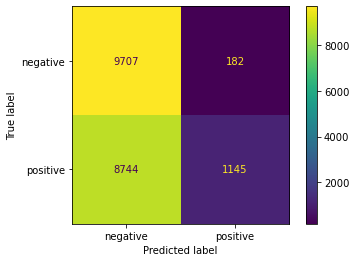

In [ ]:
train_and_evaluate(d_tree, x_train_bow, y_train_bow, x_val_bow, y_val_bow)

#### the performance of the decision tree model is summarized as follows:
- 86% of the comments predicted to be toxic were correct.
- only 12% of the identified toxic comment in the dataset were classified as toxic.

## Implementing Decision Tree on TF-IDF vectors

- this will be done using GridSearchCV

In [ ]:
d_tree = DecisionTreeClassifier()
param_grid = {'criterion' : ['gini', 'entropy'], 'max_depth' : [5, 6, 7], 'max_features' : ['sqrt'],
              'random_state':[0]}

In [ ]:
best_param = best_param_search(X=tf_feat, y=y, estimator=d_tree, param_grid=param_grid)

In [ ]:
best_param

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'random_state': 0}

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


train accuracy : 0.549
              precision    recall  f1-score   support

           0       0.53      0.98      0.68      9889
           1       0.87      0.11      0.20      9889

    accuracy                           0.55     19778
   macro avg       0.70      0.55      0.44     19778
weighted avg       0.70      0.55      0.44     19778



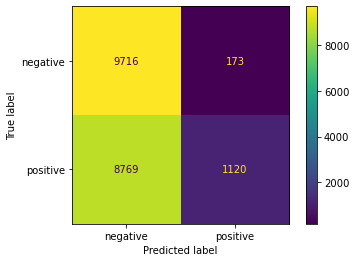

In [ ]:
d_tree = DecisionTreeClassifier(**best_params)
train_and_evaluate(d_tree, x_train_tf, y_train_tf, x_val_tf, y_val_tf)

#### the performance of the decision tree model on tf-idf features is summarized as follows:
- 87% of the comments predicted to be toxic were correct.
- However, only 11% of the identified toxic comment in the dataset were classified as toxic.

## Ensemble Model
### GradientBoosting on BOW features

In [ ]:
#import ensemble algoritm
from sklearn.ensemble import GradientBoostingClassifier

train accuracy : 0.769
              precision    recall  f1-score   support

           0       0.70      0.93      0.80      9889
           1       0.90      0.60      0.72      9889

    accuracy                           0.77     19778
   macro avg       0.80      0.77      0.76     19778
weighted avg       0.80      0.77      0.76     19778



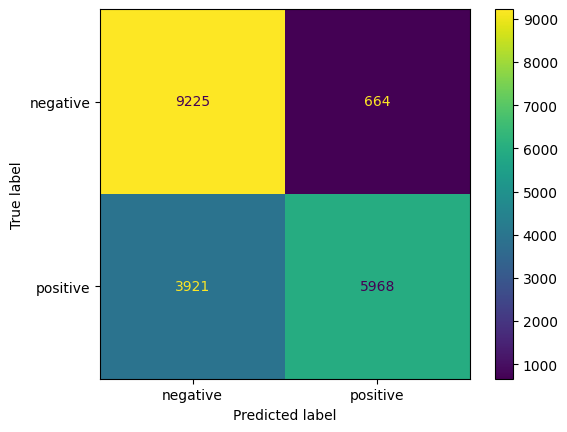

In [ ]:
#initialize the model
grb = GradientBoostingClassifier(n_estimators=100,random_state=0)

grb_performance = train_and_evaluate(grb, x_train_bow, y_train_bow, x_val_bow, y_val_bow)
grb_performance

#### the performance of the GradientBoosting model on BOW features is summarized as follows:
- 90% of the comments predicted to be toxic were correct.
- However, only 60% of the identified toxic comment in the dataset were classified as toxic.

### GradientBoosting on TF-IDF features

In [ ]:
#initialize the model
grb = GradientBoostingClassifier(n_estimators=100,random_state=0)

grb_performance = train_and_evaluate(grb, x_train_tf, y_train_tf, x_val_tf, y_val_tf)
grb_performance

###  Search for best hyper-parameters for the GradientBoosting model

In [ ]:
#step1: initialize the algoritm
# grb = GradientBoostingClassifier()

# #step2: define search features for gridsearch
# param_grid = {'loss' : ['log_loss', 'deviance', 'exponential'],
#               'n_estimators' : [100], 'max_depth' : [3,4],
#               'random_state':[0]}

# # #step3: implemet a gridsearch with specified hyper-parameter
# best_params = best_param_search(X=bow_feat, y=y, estimator=grb, param_grid=param_grid)

# #step4: initialize the algoritm with the best hyper-parameters obtained from the search
# grb = GradientBoostingClassifier(**best_params)

# #step5: train and evaluate the model
# train_and_evaluate(grb, x_train_bow, y_train_bow, x_val_bow, y_val_bow)

# Unsupervised Learning

## VADER Sentiment

In [ ]:
#import relevant package
from nltk.sentiment import vader

#intialize the vader sentiment
vad = vader.SentimentIntensityAnalyzer()

In [ ]:
def vad_sentiment(text):
    """
    returns the compound polarity score of the text.

    """
    #compute the polarity score of a text
    score = vad.polarity_scores(text)

    #select the compund score
    comp_score = score['compound']

    #if compound score < 0
    if comp_score < 0:
        #return it as 0
        return 0
    #if compound score >= 0
    elif comp_score >= 0:
        #return it as 1
        return 1

In [ ]:
def metrics_score(actual, predicted):

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['negative', 'positive'], yticklabels = ['negative', 'positive'])

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

              precision    recall  f1-score   support

           0       0.35      0.35      0.35     98890
           1       0.35      0.35      0.35     98890

    accuracy                           0.35    197780
   macro avg       0.35      0.35      0.35    197780
weighted avg       0.35      0.35      0.35    197780



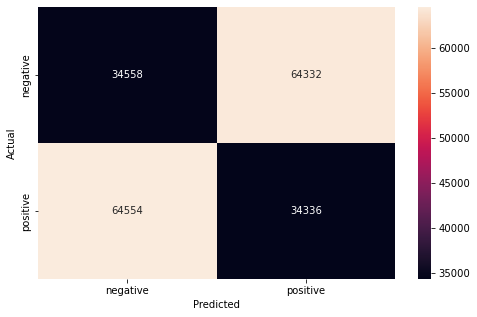

In [ ]:
#Step1: make a copy of the data
data_copy = data.copy()

#Step2: apply the function to 'comment_text'
data_copy['vader'] = data_copy['comment_text'].apply(vad_sentiment)

#step3: measure the performance
metrics_score(data_copy['toxic_class'], data_copy['vader'])


#### the performance of the VaderSentiment unsupervised model is summarized as follows:
- 35% of the comments predicted to be toxic were correct.
- However, only 35% of the identified toxic comment in the dataset were classified as toxic which is an improvement from the 12% recorded from decision tree model

## TextBlob

In [ ]:
#import relevant package
from textblob import TextBlob

def TB(text):
    """
    returns class 1 or 0 depending on the polarity score obtained from textblob sentiment analysis

    text: 'comment_text'
    """
    #obtain polarity score
    polarity = TextBlob(text).sentiment.polarity

    #if score < 0
    if polarity < 0:
    #return o
        return 0
    #if score >= 0
    elif polarity >= 0:
    #return 1
        return 1

              precision    recall  f1-score   support

           0       0.33      0.25      0.29     98890
           1       0.40      0.50      0.44     98890

    accuracy                           0.38    197780
   macro avg       0.37      0.38      0.37    197780
weighted avg       0.37      0.38      0.37    197780



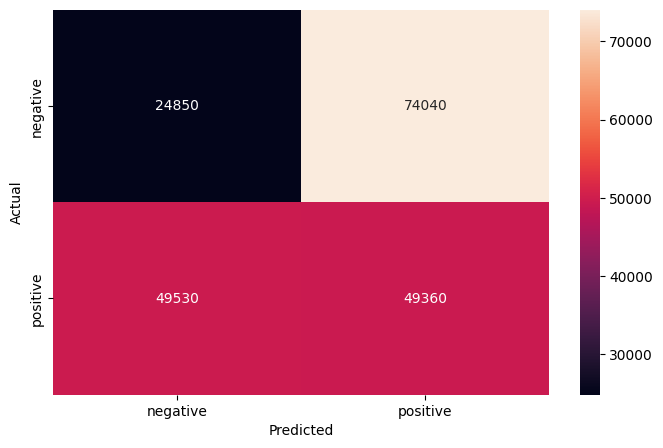

In [ ]:
#Step1: make a copy of the data
#data_copy = data.copy()



#step2: Calculate the polarity score of the 'comment_text'
#data_copy['TB_polarity']  = data_copy['comment_text'].apply(lambda text: TB(text))


#step3: review the performance
metrics_score(data_copy['toxic_class'], data_copy['TB_polarity'])


#### the performance of the TextBlob model on BOW features is summarized as follows:
- 40% of the comments predicted to be toxic were correct.
- However, only 50% of the identified toxic comment in the dataset were classified as toxic.

# Dense vectors

## Word2vec

#### the following steps will be carried out in implementing Word2Vec, skipgram and FastText
- step1: import relevant packages
- step2: because word2vec does not operate similar way as count vectorizer, I get all the text inside  a single list.
- step3: train the word2vec model
- step4: build a function that will obtain the word embeddings.
    1. every sentence in each index or each row has words
    2. each of these words have a dense representation of specified vector size, example, 100 vectors
    3. thus each sentence has a many dense representation of 100 vectors per word that it contains
    4. these representations are averaged for each row (for each word in the sentence) to obtain 100 dense vector representations that attempt to explain that sentence.
    5. at the end, we will see that each row (sentence) is represented by a vector of 100 dimensions in this case
- step5: split the dataset
- step 6: train the GradientBoosting model.

In [ ]:
data.head()

,comment_text,toxic_class
145685,"So GW didn't have anything to do with it? Wow. \nHow is reporting what the idiot trump says, pc? Trump lies continuously and gets caught and you don't care. He said Hillary set the debates but they were selected back in September by a bipartisan group. He said the NFL sent him a letter complaining about it. The NFL denies it. He said he refused to see the Koch brothers but they say they never asked him. He says he can't release his taxes because the IRS is auditing them. The IRS says he can release them if he wants. Why doesn't he want to? Might it show he's nowhere near a billionaire? Or who he actually does business with? He doesn't even know that Russia annexed Crimea from Ukraine in 2014. The sad thing is his supporters don't care. They seem to be just as ignorant as he is.",1
20689,C'mon uncalled for. Just because the husband was convicted of ripping off people in his funeral service business and had to spend a couple of weeks in the slammer does make her a snob. Actually I posted once on her former SA column for being condescending to some people and she deleted my post. Actually you are probably right. Never mind.....,0
58613,"I agree. ""Fake news"" qualifies as boring. I'm pretty weary on the subject of Haitian border-jumpers, too (even though it wasn't caused by Trump-the-outrageous, but by our own PM's foot-in-tweet); roll my eyes about gender equality. Enough already. \n\nOne of the reasons: overload. 24/7 media. Example: Tornado rips through little Lachute, (pop: 12,500) Body count? Nil. Gotta be injuries, then. Not one. Weird weather due to Global Warming? Nope; 6th Tornado of the year, which, Meteorologist Amelie Bertrand assured reporters, ""was right on the mean"" because the season ends in about a month. But last night, on and on and on via CBC. Why? Easy stuff. While the same 5-6 shots of damage cycled endlessly,in the background during endless interviews? CBC van parked on the street. Boredom? I was reaching for the remote at about the six minute (!) mark.\n\nDangerous, though. CBC Washington reporter's final comment on another wild week of Trump? ""It's starting to feel...normal.""\n\nUh-oh.",0
136301,"""Proposed pipeline""? The court battle up until now has been fought. All necessary permits have been received. Permission was given to dig. Now police are enforcing court orders and enforcing rule of law. The protest needs to be done legally, without damaging property, be fought in court. To support the criminals who choose to ruin property, kill buffalo, to burn a small mountain of tires is hypocritical, illegal, and not allowed. We are a nation of laws.",1
8944,You have no idea what Muslim students will be discussing in their Friday meetings. You haven't the slightest idea what it means to be a Muslim today. All that you have is bigotry based on ancient writings. Sorry if that doesn't quite cut it in 2017.,0


In [ ]:
#step1: import relevant packages
from gensim.models import Word2Vec, FastText

#step2: append all comments in a list
wrapped_list = []
for comments in data['comment_text']:
    tokens = comments.split()
    wrapped_list.append(tokens)

#step3: define the word2vec model of 100-Dimension
model1 = Word2Vec(sentences=wrapped_list, min_count=5)

In [ ]:
#save the word2vec model
model1.save("/content/drive/MyDrive/data_science/w2v_model.model")

In [ ]:
def word_embeddings_getter(model, token_list):
    """
    this function returns an array of word-embedding vectors for each token found in the list of tokens
    model: model
    token_list: each itirative sentence in a list

    """
    embeddings = []
    vocab = set(model.wv.key_to_index) #get vocabulary

    for token in token_list: #for each  word in token_list
        if token in vocab: #if the token (word) is found in the vocab
            embeddings.append(model.wv.get_vector(token))#append the word embeddings to the list

    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    else:
        return(np.mean(embeddings, axis=0)) #return the mean of word embeddings for each word

def avg_word_emb(model, sentence):
    """
    this function applies the get_word_embeddings on each sentence
    model: model
    sentence: list containing a list of tokens
    """

    for token_list in sentence:

        word_embedding = [word_embeddings_getter(model, token_list) for token_list in sentence]
        #this will put every averaged word embedding for each sentence in a list hence we are able to retain the
        #shape of the array

        return np.array(word_embedding)

In [ ]:
model1.vector_size

100

In [ ]:
#step4: get the word embeddings
we = avg_word_emb(model=model1, sentence=wrapped_list)



In [ ]:
pd.DataFrame(we).head() #displays the word embeddings for the first 5 rows

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.428299,0.662315,-0.000663,0.330318,-0.487070,-0.468701,0.093017,0.619807,-0.167569,-0.011107,...,0.324757,-0.194141,-0.280072,-0.152409,0.433810,-0.545024,-0.069362,-0.000090,-0.231654,0.223053
1,0.223655,0.753517,-0.092271,0.445075,-0.329313,0.050048,0.000422,0.696766,-0.351766,0.183972,...,-0.008683,0.296402,-0.105288,0.196210,0.288024,-0.372895,-0.053611,-0.216462,0.168437,0.566648
2,-0.001145,0.289760,-0.140211,0.347503,-0.210273,-0.025935,0.004336,0.454243,-0.217672,-0.108882,...,0.196705,-0.084987,-0.112910,0.094708,0.168369,-0.083067,0.280573,0.232781,-0.038158,0.174525
3,-0.006541,0.648065,-0.284977,0.378491,-0.563986,0.168308,-1.086030,0.703883,0.044666,0.391703,...,0.206654,-0.844560,-0.206561,-0.196155,0.317793,-0.394712,0.489806,-0.430102,-0.386661,0.130774
4,0.280008,0.557943,-0.540722,0.343929,-0.017398,-0.427424,-0.176694,0.194721,-0.131087,-0.075047,...,-0.390566,0.161251,-0.193763,-0.083025,0.279481,0.039565,0.162160,0.241170,-0.085509,0.253867


In [ ]:
#select features and target
X = we
y = data['toxic_class']

#split the dataset into train, validation and test
x_train, x_V, y_train, y_V = train_test_split(X, y, random_state=0,stratify=y,
                                                   test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_V, y_V, random_state=0,stratify=y_V,
                                                   test_size=0.5)


              precision    recall  f1-score   support

           0       0.75      0.74      0.74      9889
           1       0.74      0.75      0.75      9889

    accuracy                           0.74     19778
   macro avg       0.74      0.74      0.74     19778
weighted avg       0.74      0.74      0.74     19778



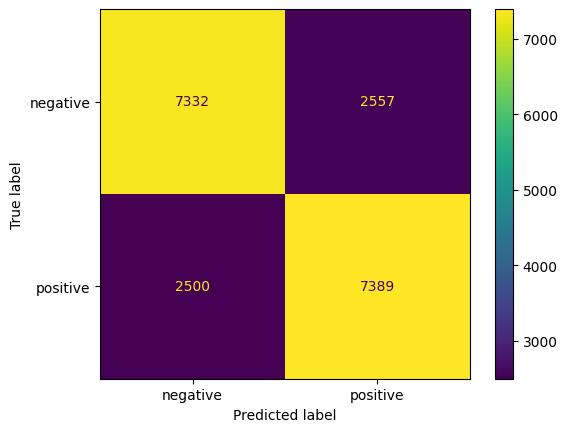

In [ ]:
#initialize the model
grb = GradientBoostingClassifier(n_estimators=100,random_state=0)

grb_m = grb.fit(x_train, y_train)

grb_performance = perf_evaluator(grb_m, x_val, y_val)
grb_performance

#### the performance of the GradientBoosting model on Word2Vec word embeddings is summarized as follows:
- 74% of the comments predicted to be toxic were correct.
- However, only 75% of the identified toxic comment in the dataset were classified as toxic.

## Implementing Skipgram

In [ ]:
from gensim.models import Word2Vec

sg = Word2Vec(sentences=wrapped_list, sg=1)
#specifying 'sg=1' implement skipgram

In [ ]:
#save the skipgram model
sg.save("/content/drive/MyDrive/data_science/skipgram_model.model")

In [ ]:
#get the word embeddings
sg_wv = avg_word_emb(model=sg, sentence=wrapped_list)

In [ ]:
len(sg_wv)

197780

In [ ]:
pd.DataFrame(sg_wv).head() #displays the word embeddings for the first 5 rows

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.137263,0.277368,0.111511,0.065786,-0.032748,-0.346987,0.070952,0.490626,-0.272032,-0.021276,...,0.129130,0.108304,-0.018563,-0.053289,0.299464,0.016268,0.235459,-0.223846,-0.013425,-0.026770
1,-0.085034,0.204992,0.053229,0.081000,0.060516,-0.242753,0.042363,0.410418,-0.281179,-0.049838,...,0.073252,0.224951,0.023392,0.070933,0.268202,0.070578,0.225987,-0.185171,0.038653,0.116933
2,-0.123723,0.196960,0.022953,0.126097,0.040394,-0.272326,0.072313,0.419637,-0.152783,-0.025847,...,0.258269,0.072408,-0.002830,0.056951,0.249713,0.092016,0.272923,-0.094256,0.039988,0.003218
3,-0.132565,0.225334,0.013252,0.138636,-0.154393,-0.226760,-0.157381,0.551202,-0.297345,0.070363,...,0.131216,-0.036381,0.013230,-0.026571,0.269862,-0.089753,0.308478,-0.219477,-0.034957,0.012548
4,-0.067679,0.259187,-0.041291,0.202689,0.073709,-0.363355,-0.038517,0.269184,-0.283362,-0.097790,...,0.158565,0.199287,0.001711,-0.043574,0.395249,0.101282,0.177143,-0.145254,0.066540,0.089222


In [ ]:
#select features and target
X = sg_wv
y = data['toxic_class']

#split the dataset into train, validation and test
x_train_sg, x_V, y_train_sg, y_V = train_test_split(X, y, random_state=0,stratify=y,
                                                   test_size=0.2)
x_val_sg, x_test_sg, y_val_sg, y_test_sg = train_test_split(x_V, y_V, random_state=0,stratify=y_V,
                                                   test_size=0.5)


              precision    recall  f1-score   support

           0       0.76      0.75      0.76      9889
           1       0.76      0.77      0.76      9889

    accuracy                           0.76     19778
   macro avg       0.76      0.76      0.76     19778
weighted avg       0.76      0.76      0.76     19778



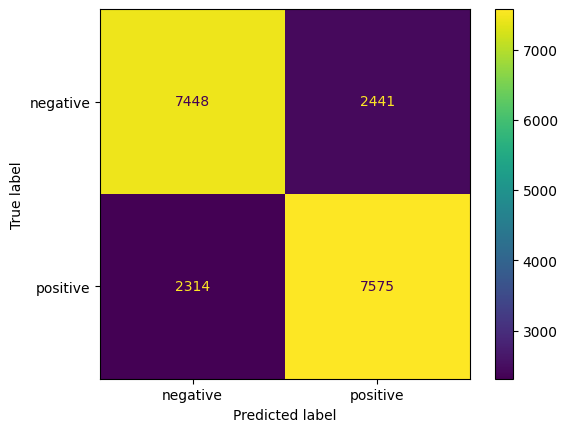

In [ ]:
#initialize the model
grb = GradientBoostingClassifier(n_estimators=100,random_state=0)

grb_m = grb.fit(x_train_sg, y_train_sg)

grb_performance = perf_evaluator(grb_m, x_val_sg, y_val_sg)
grb_performance

#### the performance of the GradientBoosting model on skipgram word embeddings is summarized as follows:
- 76% of the comments predicted to be toxic were correct.
- However, only 77% of the identified toxic comment in the dataset were classified as toxic.

# Fast Text
#### skipgram method will be implemented instead of word2vec because superior performance was obtained using the skipgram word embdeddings.

In [ ]:
#step1: import relevant packages
from gensim.models import FastText

In [ ]:
#step2: build the fasttext model
ft = FastText(sentences=wrapped_list, sg=1, seed=10, word_ngrams=1)



In [ ]:
#save the fasttext model
ft.save("/content/drive/MyDrive/data_science/fasttext_model.model")

In [ ]:
#step3: get the word embeddings
ft_wv = avg_word_emb(model=ft, sentence=wrapped_list)

In [ ]:
pd.DataFrame(ft_wv).head() #displays the word embeddings for the first 5 rows

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.241999,-0.234132,0.218674,-0.219774,0.140962,-0.079997,-0.072619,-0.222791,-0.401181,-0.180568,...,-0.011769,0.161906,-0.240923,-0.022418,0.106514,-0.149581,0.172314,-0.446293,0.082887,0.461513
1,0.262945,-0.252382,0.230599,-0.254484,-0.005363,-0.220422,0.071635,-0.215039,-0.353912,-0.122167,...,-0.001011,0.152843,-0.267147,-0.037213,0.106572,-0.162128,0.196237,-0.374763,0.101749,0.414423
2,0.150588,-0.232604,0.188337,-0.204475,0.097330,-0.131464,-0.004060,-0.163918,-0.435839,-0.138329,...,-0.073956,0.173655,-0.268107,-0.066992,0.099252,-0.185511,0.146390,-0.311538,0.079830,0.347342
3,0.213904,-0.149178,0.048750,-0.231285,-0.060252,-0.065990,-0.106871,-0.199003,-0.406786,-0.335860,...,0.137139,0.126357,-0.299719,-0.048305,0.184210,-0.176832,0.098196,-0.383216,0.161577,0.427766
4,0.117811,-0.248261,0.187444,-0.118595,0.123583,-0.160019,-0.003180,-0.089569,-0.475624,-0.243143,...,-0.130453,0.107637,-0.119346,-0.050861,0.216074,-0.132059,0.142375,-0.375932,0.080883,0.412998


In [ ]:
#step4: select features and target
X = ft_wv
y = data['toxic_class']


#step5: split the dataset into train, validation and test
x_train_ft, x_V, y_train_ft, y_V = train_test_split(X, y, random_state=0,stratify=y,
                                                   test_size=0.2)
x_val_ft, x_test_ft, y_val_ft, y_test_ft = train_test_split(x_V, y_V, random_state=0,stratify=y_V,
                                                   test_size=0.5)


              precision    recall  f1-score   support

           0       0.76      0.75      0.76      9889
           1       0.75      0.76      0.76      9889

    accuracy                           0.76     19778
   macro avg       0.76      0.76      0.76     19778
weighted avg       0.76      0.76      0.76     19778



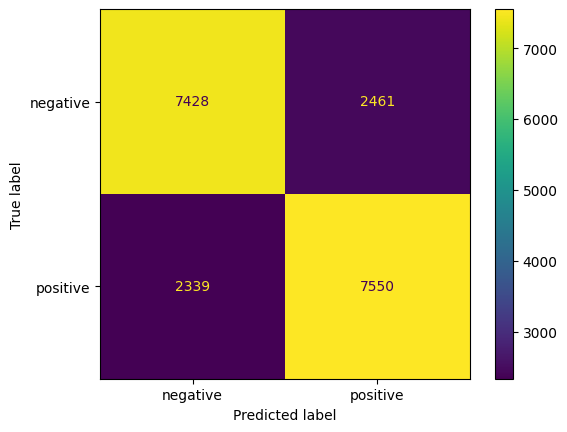

In [ ]:
#train and evaluate the GradientBoosting model
grb = GradientBoostingClassifier(n_estimators=100,random_state=0)

grb_m = grb.fit(x_train_ft, y_train_ft)

grb_performance = perf_evaluator(grb_m, x_val_ft, y_val_ft)
grb_performance

#### the performance of the GradientBoosting model on FastText word embeddings is summarized as follows:
- 75% of the comments predicted to be toxic were correct.
- However, only 76% of the identified toxic comment in the dataset were classified as toxic.

# GloVe

#### the implementation of Glove model, will be done as follows:
- step1: define the path
- step2: read the glove file.txt
- step3: select the features
- step4: split the data
- step5: obtain glove representation for each set
- step6: measure the performance on the GradientBoosting model

#### Please note that the file used here is the "Glove twitter 100d".

In [ ]:
# glv_path = "/Users/user/Downloads/glove/glove.twitter.27B.100d.txt"
# glv_path300 = "/Users/user/Downloads/glove-2/glove.6B.300d.txt"

glv_path = "/content/drive/MyDrive/data_science/glove.twitter.27B.100d.txt"
embeddings_index = {}

f = open(glv_path, encoding='utf8')

for line in f:
    #splitting each line
    values = line.split()

    word = values[0]

    coefs = np.array(values[1:], dtype='float32')

    embeddings_index[word] = coefs

f.close()

print("found %s word vectors" % len(embeddings_index))

found 1193514 word vectors


In [ ]:
from nltk.tokenize import word_tokenize

def glove_emb(sentences):
    #tokenize the sentence
    tokens = word_tokenize(sentences)
    #create an empty list to store word vectors
    emb = []
    for word in tokens:
        try:
            #if word is in glove vocab
            emb.append(embeddings_index[word])
        except:
            #to avoid errors skip it
            continue

    embeddings = np.sum(emb, axis=0) #sum because some words may not
#be present in the glove vocab
    #return embeddings

    if type(embeddings) != np.ndarray:
        return np.zeros(100)
    else:
        return embeddings / np.sqrt((embeddings ** 2).sum())

In [ ]:
#step3: select features and target
X = data['comment_text']
y = data['toxic_class']


#step4: split the dataset into train, validation and test
x_train, x_V, y_train, y_V = train_test_split(X, y, random_state=0,stratify=y,
                                                   test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_V, y_V, random_state=0,stratify=y_V,
                                                   test_size=0.5)


In [ ]:
#step5: obtain glove representation for each set
x_train_glove = [glove_emb(sent) for sent in x_train]
x_val_glove = [glove_emb(sent) for sent in x_val]
x_test_glove = [glove_emb(sent) for sent in x_test]

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      9889
           1       0.75      0.75      0.75      9889

    accuracy                           0.75     19778
   macro avg       0.75      0.75      0.75     19778
weighted avg       0.75      0.75      0.75     19778



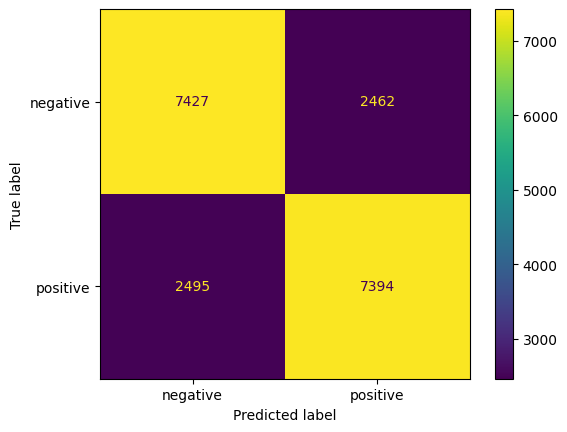

In [ ]:
#train and evaluate the GradientBoosting model
grb = GradientBoostingClassifier(n_estimators=100,random_state=0)

grb_m = grb.fit(x_train_glove, y_train)

grb_performance = perf_evaluator(grb_m, x_val_glove, y_val)
grb_performance

## Implementing Recurrent Neural Network model

#### this will be implemented with the following steps:
- step1: import relevant package
- step2: tokenize the comments
- step3: pad the sequence of integers
- step4: split the dataset
- step5: build a recall score calculator or callable class
- step6: define callbacks
- step7: build the model
- step8: train and evaluate the model

### step1: Import relevant packages

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential #for adding layers
from tensorflow.keras.layers import Input, Dropout, TextVectorization, Dense, SimpleRNN, LSTM, Embedding #for different layers


from tensorflow.keras.optimizers import Adam, SGD #import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #to save best performing model and help prevent overfiting
from tensorflow.keras.utils import to_categorical #to categorize each class of the target
from tensorflow.keras.preprocessing.text import Tokenizer #to tokenize the texts
from tensorflow.keras.preprocessing.sequence import pad_sequences #to enforce uniform length of data

from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


## step2: Tokenize the comments


In [ ]:
#initialize the tokenizer
tokenizer = Tokenizer(num_words=1000)

#fit on data to update vocabulary
tokenizer.fit_on_texts(data['comment_text'].values)

#convert text to sequence of integers
X = tokenizer.texts_to_sequences(data['comment_text'].values)



## step3: pad the sequence
- to reduce the problem of sparisity, instead of using maximum length of comment as the max length, i will obtain the descriptive stats of the length of all the comments as this will help me know the best padding length to use.

In [ ]:

length = []
#for each row in the data
for i in range(len(data['comment_text'].values)):
  #append the length of each string to the list
  length.append(len(data['comment_text'][i].split()))

#convert the list to a series
length_series = pd.Series(length)
#give a descriptive stats of it
print(length_series.describe())

count    197780.000000
mean         26.121736
std          23.176652
min           0.000000
25%           9.000000
50%          18.000000
75%          36.000000
max         305.000000
dtype: float64


- the result indicates that 75% of the comments are not longer than 36 chars in length.
- the max. length of the comments however is 305.

#### i will set the max_len of the padding operation to 100.

In [ ]:
#to ensure consistency in length
X = pad_sequences(X, maxlen=100)
y = data['toxic_class']



## step4: plit the dataset into train, validation and test

In [ ]:
x_train, x_V, y_train, y_V = train_test_split(X, y, random_state=0,stratify=y,
                                                   test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_V, y_V, random_state=0,stratify=y_V,
                                                   test_size=0.5)


## step5: build a recall score calculator or callable class

In [ ]:
#build a recall score callable metrics
from sklearn.metrics import recall_score
class Recall_Calculate(tf.keras.callbacks.Callback):
    #use the class constuctor to initialize the attributes

    def __init__(self, x, y):
        """
        self: object or instance of the class
        x: features
        y: target
        """
        #callback should be a child class od recall_calculate and retains the attributes
        super(Recall_Calculate, self).__init__()
        self.x = x
        self.y = y
        self.recall_values = []  # List to store recall values


    def on_epoch_end(self, epoch, logs=None):
        x = self.x
        y = self.y

        y_pred = self.model.predict(x)
        y_pred = tf.argmax(y_pred, axis=1).numpy()
        recall = recall_score(y, y_pred, average='weighted')
        self.recall_values.append(recall) #store the recall values after each epoch
        print(f"Validation Recall: {recall}")



## step6: define callbacks

In [ ]:
# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=3)

#define modelcheckpoint to save best model
path = '/content/drive/MyDrive/data_science/project/model'
mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_accuracy', mode='max')

#initialize the recall metrics
recall_callback = Recall_Calculate(x_val, y_val)

## step7: build the model

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
def RNN_model(embedding_dims=100,output_sequence_length=100, hidden_dims=32):
    model = Sequential()



    model.add(Embedding(1000, output_dim=embedding_dims,input_length=X.shape[1]))

    model.add(SimpleRNN(units=hidden_dims))

    model.add(Dense(2, activation ='sigmoid'))
    #model.add(Dropout(0.3))
    model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

    return model

In [ ]:
rnn_1 = RNN_model()

rnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 104,322
Trainable params: 104,322
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train_c = to_categorical(y_train)
y_val_c = to_categorical(y_val)
y_test_c = to_categorical(y_test)


## step8: train and evaluate the model

In [ ]:
history = rnn_1.fit(x_train, y_train_c, batch_size=64,
        validation_data= (x_val, y_val_c), epochs=5, callbacks=[es, mc,recall_callback])

Epoch 1/5
2472/2473 [============================>.] - ETA: 0s - loss: 0.4643 - accuracy: 0.7879

619/619 [==============================] - 7s 11ms/step
Validation Recall: 0.8106481949641016
2473/2473 [==============================] - 166s 66ms/step - loss: 0.4643 - accuracy: 0.7879 - val_loss: 0.4327 - val_accuracy: 0.8106
Epoch 2/5
2472/2473 [============================>.] - ETA: 0s - loss: 0.4290 - accuracy: 0.8080

619/619 [==============================] - 7s 11ms/step
Validation Recall: 0.8109515623419962
2473/2473 [==============================] - 145s 58ms/step - loss: 0.4290 - accuracy: 0.8080 - val_loss: 0.4234 - val_accuracy: 0.8110
Epoch 3/5
619/619 [==============================] - 6s 9ms/step
Validation Recall: 0.8103448275862069
2473/2473 [==============================] - 141s 57ms/step - loss: 0.4102 - accuracy: 0.8172 - val_loss: 0.4244 - val_accuracy: 0.8103
Epoch 4/5
619/619 [==============================] - 6s 9ms/step
Validation Recall: 0.8097380928304176
2473/2473 [==============================] - 129s 52ms/step - loss: 0.4093 - accuracy: 0.8176 - val_loss: 0.4244 - val_accuracy: 0.8097
Epoch 5/5
619/619 [==============================] - 7s 12ms/step
Validation Recall: 0.8094852866821721
2473/2473 [==============================] - 129s 52ms/step - loss: 0.4048 - accuracy: 0.8188 - val_loss: 0.4219 - val_accuracy: 0.8095
Epoch 5: early stopping


- the

### Visualize the RNN Model Performance

In [ ]:
recall_callback.recall_values

[]

In [ ]:

def view_perf(history, recall_vals):
  """
  plots the accuracy, val_accuracy and recall_score against epochs
  """
  #define accuracy
  acc = history.history['accuracy']

  #define validation_accuracy
  val_acc = history.history['val_accuracy']

  #define recall_values
  #recall_vals = recall_values

  #specify epochs
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize= (5,5)) #set figure size
  plt.plot(epochs, acc, label="Train Accuracy") #plot accuracy against epochs
  plt.plot(epochs, val_acc, label="validation accuracy") #plot val_acc against epcohs
  #plt.plot(epochs, recall_vals, label="recall values")#plot recall values against epochs

  plt.legend(loc='best') #display the legends at the best location in the chart

  plt.show()#show the plot

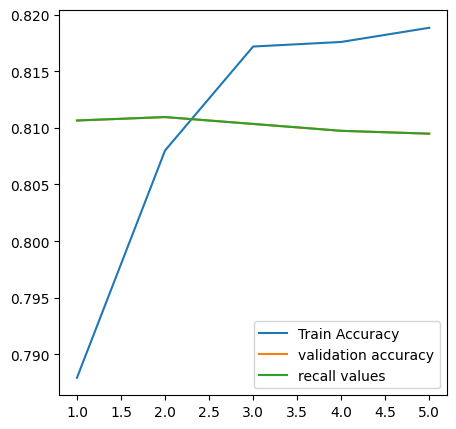

In [ ]:
recall_values = recall_callback.recall_values #recall scores
view_perf(history, recall_values)

- the recall score gotten from the RNN model is about 0.81. This means that 81% of the toxic comments in the dataset were rightly classified as toxic.
- the accuracy was 0.81 which indicates that 81% of the comments predicted to be toxic were accurate.

In [ ]:
#evaluate performance on test set
rnn_1.evaluate(x_test, y_test_c)

619/619 [==============================] - 10s 16ms/step - loss: 0.4174 - accuracy: 0.8123


[0.4174182415008545, 0.8123167157173157]

- a similar accuracy was obtained on the test set. this suggest that the model generalizes well.

## LSTM

In [ ]:
def lstm(embedding_dims=100,output_sequence_length=100, hidden_dims=32):
    model = Sequential()

    model.add(Embedding(1000, output_dim=embedding_dims,input_length= X.shape[1]))

    model.add(LSTM(units=hidden_dims))

    model.add(Dense(2, activation ='sigmoid'))
    #model.add(Dropout(0.3))
    model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

    return model

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
lstm_1 = lstm()

lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 117,090
Trainable params: 117,090
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = lstm_1.fit(x_train, y_train_c, batch_size=64,
        validation_data= (x_val, y_val_c), epochs=5, callbacks=[es, mc,recall_callback])

Epoch 1/5
2473/2473 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8057

619/619 [==============================] - 10s 15ms/step
Validation Recall: 0.8141369198098898
2473/2473 [==============================] - 263s 104ms/step - loss: 0.4248 - accuracy: 0.8057 - val_loss: 0.4101 - val_accuracy: 0.8141
Epoch 2/5
2473/2473 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.8181

619/619 [==============================] - 11s 17ms/step
Validation Recall: 0.8145919708767317
2473/2473 [==============================] - 247s 100ms/step - loss: 0.4019 - accuracy: 0.8181 - val_loss: 0.4133 - val_accuracy: 0.8146
Epoch 3/5
2473/2473 [==============================] - ETA: 0s - loss: 0.3958 - accuracy: 0.8209

619/619 [==============================] - 11s 17ms/step
Validation Recall: 0.8162604914551522
2473/2473 [==============================] - 231s 93ms/step - loss: 0.3958 - accuracy: 0.8209 - val_loss: 0.4088 - val_accuracy: 0.8163
Epoch 4/5
619/619 [==============================] - 12s 19ms/step
Validation Recall: 0.8159065628476084
2473/2473 [==============================] - 280s 113ms/step - loss: 0.3901 - accuracy: 0.8236 - val_loss: 0.4109 - val_accuracy: 0.8159
Epoch 5/5
619/619 [==============================] - 12s 19ms/step
Validation Recall: 0.8136313075133987
2473/2473 [==============================] - 261s 105ms/step - loss: 0.3843 - accuracy: 0.8260 - val_loss: 0.4139 - val_accuracy: 0.8136


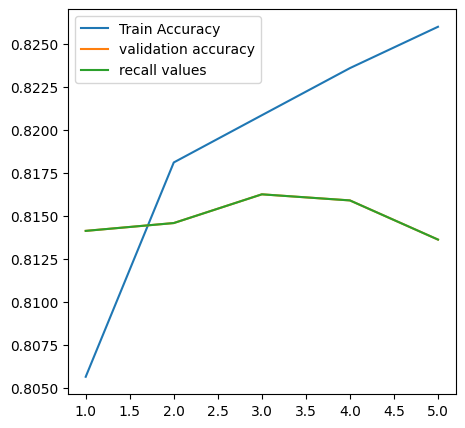

In [ ]:
recall_values = recall_callback.recall_values[5:] #recall scores
view_perf(history_lstm, recall_values)

- a higher recall value was gotten at the 3rd epoch.
- the highest train accuracy obtained was 0.825
- the model overfits from the 2nd epoch

## evaluate on test set

In [ ]:
#evaluate performance on text set
lstm_1.evaluate(x_test, y_test_c)

619/619 [==============================] - 16s 25ms/step - loss: 0.4096 - accuracy: 0.8171


[0.4096389412879944, 0.8170694708824158]

### adding a dropout layer

In [ ]:
def lstm(embedding_dims=100,output_sequence_length=100, hidden_dims=32):
    model = Sequential()

    model.add(Embedding(1000, output_dim=embedding_dims,input_length= X.shape[1]))

    model.add(LSTM(units=hidden_dims))
    model.add(Dropout(0.4)) #set dropout
    model.add(Dense(2, activation ='sigmoid'))

    model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

    return model

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
lstm_2 = lstm()

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 117,090
Trainable params: 117,090
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = lstm_2.fit(x_train, y_train_c, batch_size=64,
        validation_data= (x_val, y_val_c), epochs=5, callbacks=[es, mc,recall_callback])

Epoch 1/5
619/619 [==============================] - 10s 14ms/step
Validation Recall: 0.8134290625948023
2473/2473 [==============================] - 217s 86ms/step - loss: 0.4313 - accuracy: 0.8046 - val_loss: 0.4133 - val_accuracy: 0.8134
Epoch 2/5
619/619 [==============================] - 11s 17ms/step
Validation Recall: 0.8168672262109414
2473/2473 [==============================] - 225s 91ms/step - loss: 0.4064 - accuracy: 0.8184 - val_loss: 0.4097 - val_accuracy: 0.8169
Epoch 3/5
619/619 [==============================] - 11s 17ms/step
Validation Recall: 0.817120032359187
2473/2473 [==============================] - 221s 89ms/step - loss: 0.4007 - accuracy: 0.8200 - val_loss: 0.4092 - val_accuracy: 0.8171
Epoch 4/5
619/619 [==============================] - 11s 17ms/step
Validation Recall: 0.8169177874405905
2473/2473 [==============================] - 213s 86ms/step - loss: 0.3967 - accuracy: 0.8218 - val_loss: 0.4103 - val_accuracy: 0.8169
Epoch 5/5
619/619 [==================

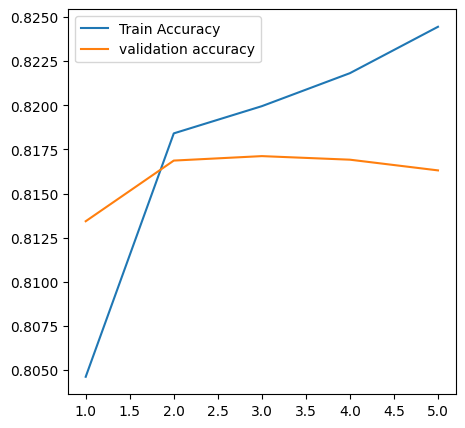

In [ ]:
recall_values = recall_callback.recall_values[5:] #recall scores
view_perf(history_lstm,recall_values)

- the model overfits at the second epoch

# Scopes of Improvement
- a better performance may be obtained by implementing hyper-parameter tuning on the RNN and LSTM model as this will give the best set of hyper-parameters.

- increasing the number of layers, neurons as well as applying dropout layers to combat overfiting might enhance the performance of the RNN and LSTM models.

- since the TF-IDF features gave the best performance, increasing the maximum_features might increase the performance of the supervised model further.

- a BERT architecture can be implemented to evaluate the performance.